# Hebbian Learning 



In [158]:
import numpy as np
import matplotlib.pyplot as plt

# Display settings
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

seed = 42
np.random.seed(seed)
# For reproducibility
rng = np.random.default_rng(seed)

# hints: rng.multivariate_normal gives you 2-D gaussians.
# .       quiver let's you plot actual vector arrows.

## Exercise 1 • Sampling inputs & visualisation

For each of the following zero‑mean 2‑D Gaussian input distributions  

$$
\Sigma_1 =
\begin{pmatrix}1 & 0\\0 & 1\end{pmatrix},\quad
\Sigma_2 =
\begin{pmatrix}1 & 0.4\\0.4 & 1\end{pmatrix},\quad
\Sigma_3 =
\begin{pmatrix}1 & 0.9\\0.9 & 1\end{pmatrix}
$$

1. Draw **500 samples** and show them in a single scatter plot (use different colours/markers).  
2. Draw one random **weight vector** $\mathbf w\in\mathbb R^2$ from a standard normal distribution and add it to the scatter plot.  
3. In a *second* panel visualise the linear activation  
$$
v = \mathbf w\cdot\mathbf u
$$
on a 2‑D grid covering $[-3,3]\times[-3,3]$ using a heatmap, together with the weight vector.


[ 0.963 -0.268]


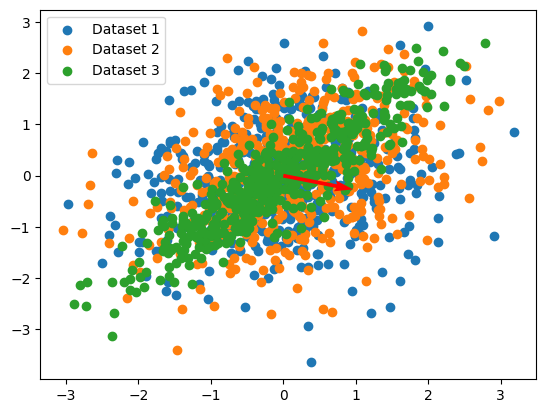

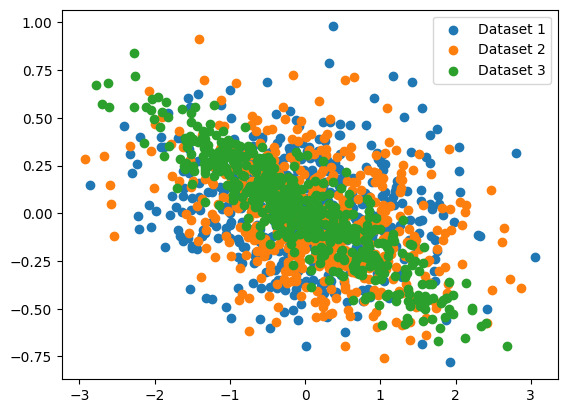

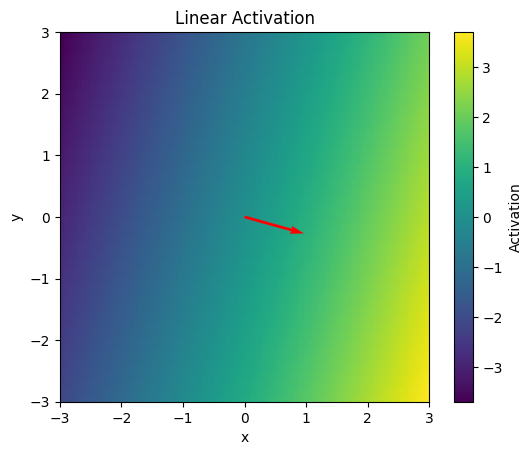

In [159]:
# hints: rng.multivariate_normal gives you 2-D gaussians.
#        quiver lets you plot actual vector arrows.

num_samples = 500
mean = [0, 0]
covs = [[[1, 0], [0, 1]], [[1, 0.4], [0.4, 1]], [[1, 0.9], [0.9, 1]]]

# create the 3 datasets
datasets = []
for distribution in covs:
    datasets.append(rng.multivariate_normal(mean, distribution, num_samples))

# plot all 3 datasets
for i, data in enumerate(datasets):
    plt.scatter(data[:, 0], data[:, 1], label=f"Dataset {i + 1}")


# draw and plot weight vector
weight = np.random.normal(size=2)
weight = weight / np.linalg.norm(weight)

print(weight)
plt.quiver(0, 0, *weight, color="red", angles="xy", scale_units="xy", scale=1)
plt.legend()
plt.show()


# create activations
activations = []
for dataset in datasets:
    activations.append(weight * dataset)

# plot all 3 activations
for i, data in enumerate(activations):
    plt.scatter(data[:, 0], data[:, 1], label=f"Dataset {i + 1}")

plt.legend()
# create grid for heatmap
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x, y)
grid_points = np.column_stack((X.ravel(), Y.ravel()))

# calculate activation for each point
activations = np.dot(grid_points, weight)
activations = activations.reshape(X.shape)

# plot heatmap
plt.figure()
plt.imshow(activations, extent=[-3, 3, -3, 3], origin="lower", aspect="equal")
plt.colorbar(label="Activation")

# plot weight vector on heatmap
plt.quiver(0, 0, *weight, color="red", angles="xy", scale_units="xy", scale=1)
plt.title("Linear Activation")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


## Exercise 2 • Dynamics of Hebbian plasticity

### 2 a — Simple Hebb rule  
Implement  Hebbian learning

\begin{align*}
\Delta\mathbf w_n &= \,v\,\mathbf u \\
v_n &= \mathbf w_n^\top\mathbf u \\
\mathbf w_{n+1} &= w + \eta \Delta\mathbf w_n
\end{align*}

* Use a learning rate $\eta=10^{-3}$.  
* Start from a different random initial vector $\mathbf w_0$.  
* Update once per randomly drawn input sample (2000 steps should suffice).  
* **Plot** the trajectory of the weight vector on top of the corresponding input scatter
  for **each** of the three input distributions
  (use a marker for every 10 updates to keep the plot readable).

Describe qualitatively what you observe.


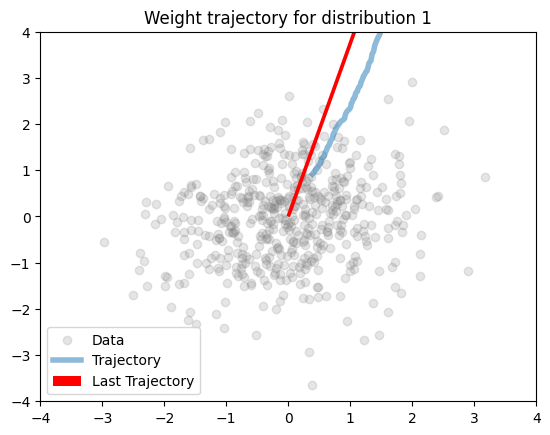

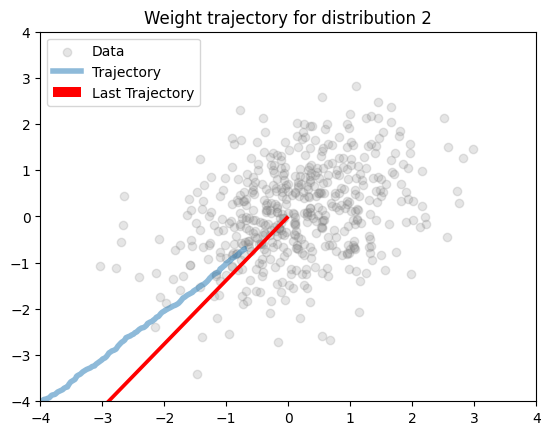

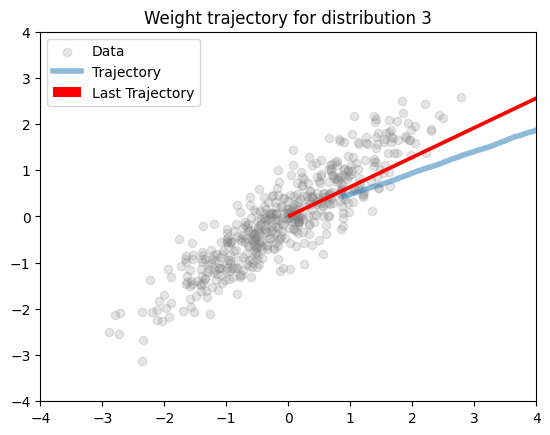

In [160]:
def hebb_update(w, u, lr):
    v = w * u
    grad = v * u
    return w + lr * grad


# you can use this function for other learning rules by changing update_fn. cov determines inputs.
def run_learning(update_fn, cov, lr=1e-3, steps=2000):
    # initialize weights, draw a data point, update weights. save weights to a vector.
    weights = np.random.normal(size=2)
    # normalize initial weights
    weights = weights / np.linalg.norm(weights)
    traj = []
    for i in range(steps):
        data = rng.multivariate_normal([0, 0], cov)
        weights = update_fn(weights, data, lr)
        if i % 10 == 0:
            traj.append(weights.copy())
    return traj


# it's helpful to standardize your plotting for the rest of the experiments.
# (ax=None lets you pass in subfigure axis)
def plot_trajectory(traj, data, title, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(data[:, 0], data[:, 1], alpha=0.2, c="gray", label="Data")

    # Plot trajectory as connected line segments
    traj = np.array(traj)
    ax.plot(traj[:, 0], traj[:, 1], alpha=0.5, label="Trajectory", linewidth=4)

    # Plot from the origin to the last trajectory point
    last_traj = traj[-1]
    ax.quiver(
        0, 0, last_traj[0], last_traj[1], color="red", scale=10, label="Last Trajectory"
    )
    ax.set_title(title)
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    ax.legend()


# run the experiment for each cov. matrix and produce the plot for each condition.
for i in range(3):
    traj = run_learning(hebb_update, covs[i])
    plot_trajectory(traj, datasets[i], f"Weight trajectory for distribution {i + 1}")

### 2 b — Catch your weight vectors! 
Repeat part (a) but clip the weight vector to a fixed maximum length  
$\lVert\mathbf w\rVert \le w_\max = 2$.

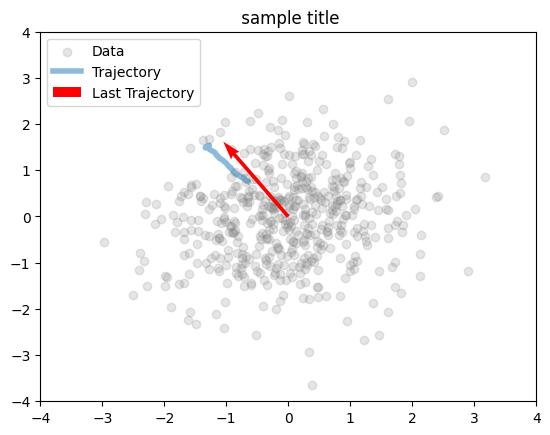

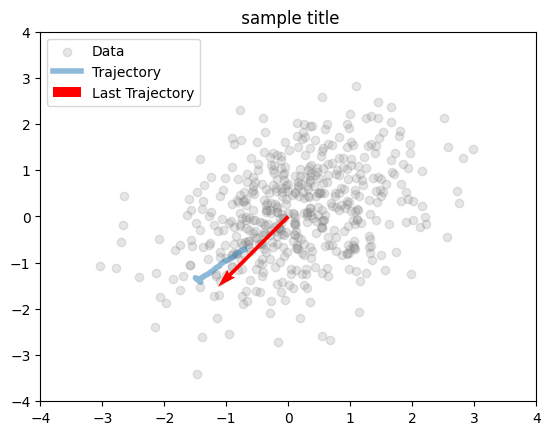

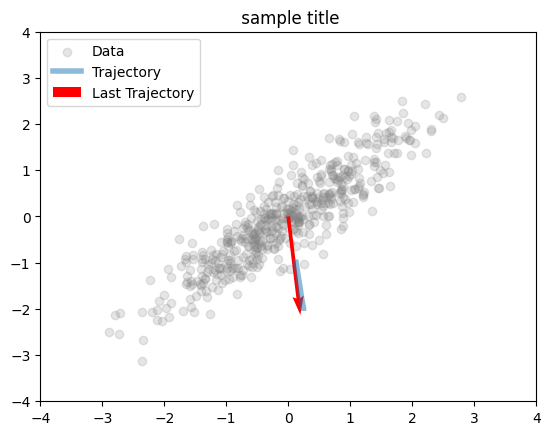

In [161]:
# implement new plasticity update
def hebb_clip_update(w, u, lr, w_max=2):
    v = w * u
    grad = v * u
    updated_w = w + lr * grad
    return updated_w / np.maximum(1, np.linalg.norm(updated_w) / w_max)


# repeat experiment (use run_learning and plot_trajectory)
# run the experiment for each cov. matrix and produce the plot for each condition.
for i in range(3):
    weight_history = run_learning(hebb_clip_update, covs[i])
    plot_trajectory(weight_history, datasets[i], " sample title")

### 2 c — Oja’s rule  
Implement Oja’s *normalising* rule

$$
\Delta\mathbf w = \eta\bigl(v\,\mathbf u - \alpha\,v^{2}\,\mathbf w\bigr)
$$

with $\alpha=1$.  
Repeat the experiment for each distribution and verify that the norm of \(\mathbf w\) converges.  
Show analytically that at equilibrium  

$$
\bigl\lVert\mathbf w\bigr\rVert = \frac{1}{\sqrt\alpha}.
$$

*(Hint: take the derivative of $\lVert\mathbf w\rVert^{2}$ and set it to zero).*

Final weight norms/lengths: [1. 1. 1.]


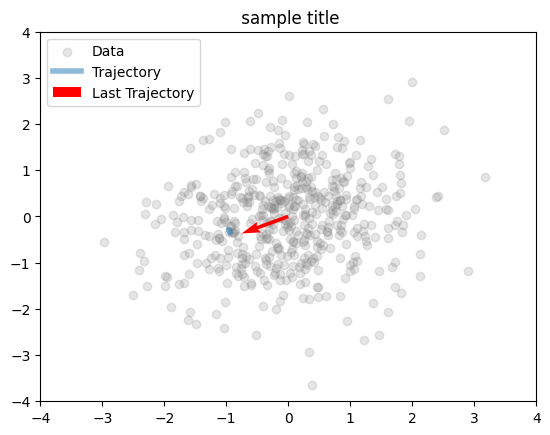

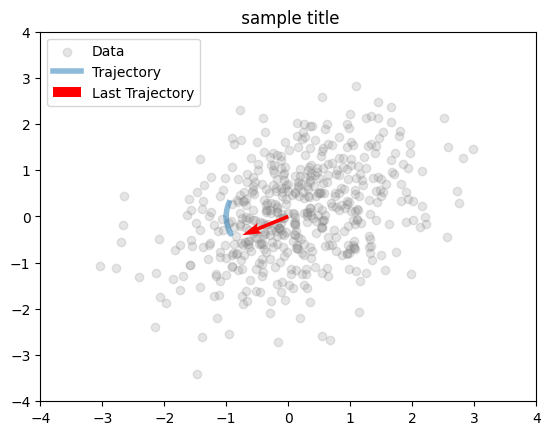

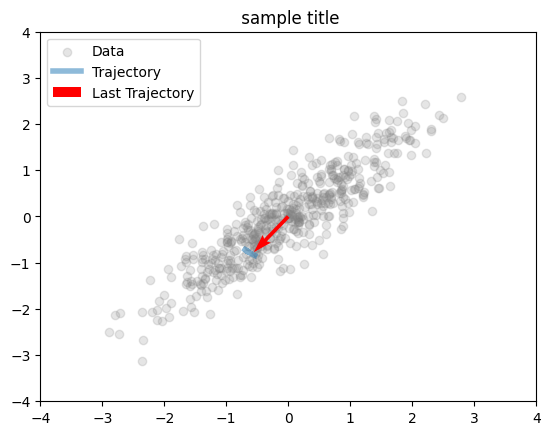

In [162]:
# implement new plasticity update
def oja_update(w, u, lr, alpha=1.0):
    v = w @ u
    return w + lr * (v * u - alpha * v**2 * w)


final_norms = []

for i in range(3):
    traj = run_learning(oja_update, covs[i])
    plot_trajectory(traj, datasets[i], " sample title")
    final_norms.append(np.linalg.norm(traj[-1]))

# repeat experiment (use run_learning and plot_trajectory)
print("Final weight norms/lengths:", np.round(final_norms, 4))

## Exercise 3 • Convergence to the First Principal Component

Using the simulations from Exercise 2, confirm *empirically* that the final weight
vector aligns with the **first principal component** (eigenvector with the
largest eigenvalue) of the input covariance matrix.

1. Compute the covariance matrix of each generated data set and its principal
   eigenvector $\mathbf e_1$.
2. Compute the cosine similarity the final weight vector $\mathbf w_*$ (from
   Oja’s rule) and $\mathbf e_1$.
3. Plot the two vectors in the same figure and report the angle in degrees.

*(A small angle ≈ 0 shows successful convergence.)*


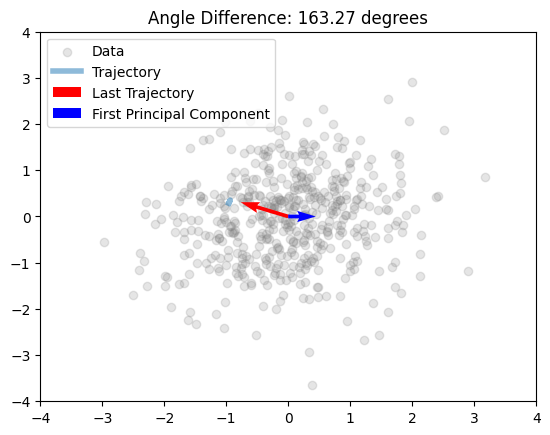

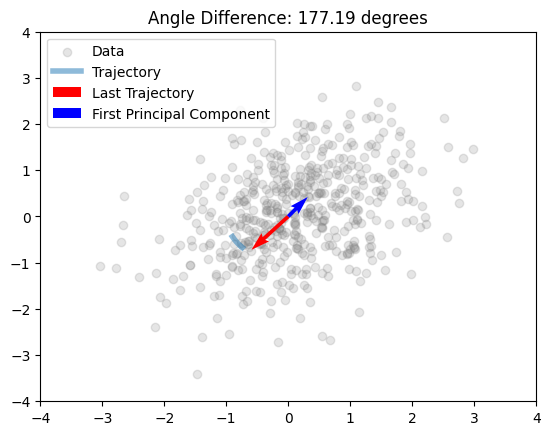

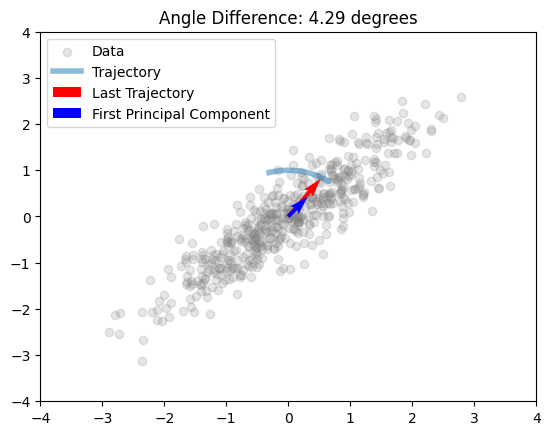

In [164]:
# compute eigenvectors, pick the biggets one (np.linalg!)
# INSERT_YOUR_REWRITE_HERE
def principal_eigenvector(cov):
    eigvals, eigvecs = np.linalg.eig(cov)
    return eigvecs[:, np.argmax(eigvals)]


# compute the cosine similarity betwee a and b
def angle_deg(a, b):
    return np.degrees(np.arccos(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))))


# plot the trajectory of the weight vector and the principal component for all 3 distributions
for i in range(3):
    traj = run_learning(oja_update, covs[i])
    final_weight = traj[-1]
    principal_component = principal_eigenvector(covs[i])
    angle_diff = angle_deg(final_weight, principal_component)
    plot_trajectory(traj, datasets[i], " sample title")
    plt.quiver(
        0,
        0,
        principal_component[0],
        principal_component[1],
        color="blue",
        label="First Principal Component",
    )
    plt.legend()
    plt.title(f"Angle Difference: {angle_diff:.2f} degrees")
    plt.show()